# GOES-17 ABI - Level 2 Fire Radiative Power and Level 1B Calibrated Radiances 

```{hint} 
<a href='https://fire.ltpy.adamplatform.eu/hub/user-redirect/lab/tree/ca_part1_workflows/figure3_GOES17_L1B_and_L2.ipynb' target='_blank'>Execute the notebook on the training platform >></a>
```

This notebook provides you an introduction to data from the [GOES-17 Advanced Baseline Imager (ABI)](https://www.goes-r.gov/spacesegment/abi.html) instrument. The ABI instrument a multi-channel passive imaging radiometer designed to observe the Youstern Hemisphere and provide variable area imagery and radiometric information of Earth’s surface, atmosphere and cloud cover. It has 16 different spectral bands, including two visible channels, four near-infrared channels, and ten infrared channels. This notebook plots the GOES-17 ABI Level 2 [Fire and Hotspot Characterisation product](https://www.goes-r.gov/products/baseline-fire-hot-spot.html) over a natural colour composite from the Level 1B [radiances](https://www.goes-r.gov/products/baseline-radiances.html) data. 

The event featured is the [August Complex fire](https://www.fire.ca.gov/incidents/2020/8/16/august-complex-includes-doe-fire/) in California, USA in 2020. This was the largest wildfire in CA history, spreading over 1,000,000 acres (over 4,000 sq km). The image shown in this notebook is taken from 7 October 2020. 

```{admonition} Basic Facts
**Spatial resolution**: `Level 2: 2km, Level 1B: 500m`<br>
**Spatial coverage**: `Western Hemisphere` <br>
**Scan time**: `5 to 15 minutes depending on mode` <br>
**Data availability**: `since 2016`
```

```{admonition} How to access the data
There are multiple ways to access the GOES-17 ABI data including from Amazon Web Services and Google Cloud Platform. You can manually download data from this [Amazon Download Page](https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) created by Brian Blaylock. The data are distributed in `netcdf` format.
```

<hr>

**Load required libraries**

In [1]:
import os
import xarray as xr
import numpy as np
import glob
from satpy.scene import Scene
from satpy import MultiScene
from satpy.writers import to_image
from satpy import find_files_and_readers

from datetime import datetime
import pyresample as prs

# Python libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.axes import Axes
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
import logging
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
logging.basicConfig(level=logging.ERROR)

<hr>

## GOES-17 Level 1B True Colour Composite

### Load and browse GOES-17 ABI Level 1B Calibrated Radiances data

GOES-17 ABI data is disseminated in the `netcdf` format. You will use the Python library `satpy` to open the data. The results in a `netCDF4.Dataset`, which contains the dataset's metadata, dimension and variable information.

Read more about `satpy` [here](https://satpy.readthedocs.io/en/stable/).

From the [Amazon Download Page](https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi), you downloaded Level-1B data for every available band on 20 August 2021 at 22:01 UTC. The data is available in the folder `../data/goes/17/level1b/2020/08/20/2201`. Let us load the data. First, you specify the file path and create a variable with the name `file_name`. Each file contains data from a single band.

In [2]:
file_name = glob.glob('../data/goes/17/level1b/2020/08/20/2201/*.nc')
file_name

['../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C04_G17_s20202332201177_e20202332203549_c20202332203589.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C06_G17_s20202332201177_e20202332203555_c20202332204010.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C02_G17_s20202332201177_e20202332203550_c20202332203573.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C01_G17_s20202332201177_e20202332203550_c20202332203579.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C03_G17_s20202332201177_e20202332203550_c20202332203597.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C05_G17_s20202332201177_e20202332203550_c20202332204004.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C14_G17_s20202332201177_e20202332203550_c20202332204048.nc',
 '../data/goes/17/level1b/2020/08/20/2201/OR_ABI-L1b-RadC-M6C10_G17_s20202332201177_e20202332203562_c20202332204031.nc',
 '../data/goes/17/level1b/2020/0

In a next step, you use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for GOES-17 Level-1B data, you can use the `abi_l1b` reader.

In [3]:
scn =Scene(filenames=file_name,reader='abi_l1b')

scn

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. To learn more about the bands of GOES-17, visit [this website](https://www.goes-r.gov/mission/ABI-bands-quick-info.html).

In [4]:
scn.available_dataset_names()

['C01',
 'C02',
 'C03',
 'C04',
 'C05',
 'C06',
 'C07',
 'C08',
 'C09',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16']

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `C01` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`.

In [5]:
scn.load(['C01'])
scn['C01']

<xarray.DataArray (y: 3000, x: 5000)>
dask.array<mul, shape=(3000, 5000), dtype=float64, chunksize=(3000, 4096), chunktype=numpy.ndarray>
Coordinates:
    crs      object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",E...
  * y        (y) float64 4.589e+06 4.588e+06 4.587e+06 ... 1.585e+06 1.584e+06
  * x        (x) float64 -2.505e+06 -2.504e+06 ... 2.504e+06 2.505e+06
Attributes:
    orbital_parameters:     {'projection_longitude': -137.0, 'projection_lati...
    long_name:              Bidirectional Reflectance
    standard_name:          toa_bidirectional_reflectance
    sensor_band_bit_depth:  10
    units:                  %
    resolution:             1000
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    platform_name:          GOES-17
    sensor:                 abi
    name:                   C01
    wavelength:             0.47 µm (0.45-0.49 µm)
    calibration:            reflectance
    modifiers:              ()
    observation_type:       Rad
    scene_abbr:             C
    scan_mode:              M6
    platform_shortname:     G17
    scene_id:               CONUS
    orbital_slot:           GOES-West
    instrument_ID:          FM2
    production_site:        WCDAS
    timeline_ID:            None
    start_time:             2020-08-20 22:01:17.700000
    end_time:               2020-08-20 22:03:55
    reader:                 abi_l1b
    area:                   Area ID: GOES-West\nDescription: 1km at nadir\nPr...
    _satpy_id:              DataID(name='C01', wavelength=WavelengthRange(min...
    ancillary_variables:    []

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [6]:
scn['C01'].attrs.keys()

dict_keys(['orbital_parameters', 'long_name', 'standard_name', 'sensor_band_bit_depth', 'units', 'resolution', 'grid_mapping', 'cell_methods', 'platform_name', 'sensor', 'name', 'wavelength', 'calibration', 'modifiers', 'observation_type', 'scene_abbr', 'scan_mode', 'platform_shortname', 'scene_id', 'orbital_slot', 'instrument_ID', 'production_site', 'timeline_ID', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [7]:
scn['C01'].attrs['start_time'], scn['C01'].attrs['end_time']

(datetime.datetime(2020, 8, 20, 22, 1, 17, 700000),
 datetime.datetime(2020, 8, 20, 22, 3, 55))

### Browse and visualize composite IDs

 composites combine three window channel of satellite data in order to get e.g. a true-color image of the scene. Depending on which channel combination is used, different features can be highlighted in the composite, e.g. dust. The satpy library offers several predefined composites options. The function `available_composite_ids()` returns a list of available composite IDs.

In [8]:
scn.available_composite_ids()

[DataID(name='airmass'),
 DataID(name='ash'),
 DataID(name='cimss_cloud_type'),
 DataID(name='cimss_green'),
 DataID(name='cimss_green_sunz'),
 DataID(name='cimss_green_sunz_rayleigh'),
 DataID(name='cimss_true_color'),
 DataID(name='cimss_true_color_sunz'),
 DataID(name='cimss_true_color_sunz_rayleigh'),
 DataID(name='cira_day_convection'),
 DataID(name='cira_fire_temperature'),
 DataID(name='cloud_phase'),
 DataID(name='cloud_phase_distinction'),
 DataID(name='cloud_phase_distinction_raw'),
 DataID(name='cloud_phase_raw'),
 DataID(name='cloudtop'),
 DataID(name='color_infrared'),
 DataID(name='colorized_ir_clouds'),
 DataID(name='convection'),
 DataID(name='day_microphysics'),
 DataID(name='day_microphysics_abi'),
 DataID(name='day_microphysics_eum'),
 DataID(name='dust'),
 DataID(name='fire_temperature_awips'),
 DataID(name='fog'),
 DataID(name='green'),
 DataID(name='green_crefl'),
 DataID(name='green_nocorr'),
 DataID(name='green_raw'),
 DataID(name='green_snow'),
 DataID(name='hi

Let us define a list of containing a single composite ID, `true_color`. The fire which will be shown is the Doe Fire, which was a part of the August Complex fires. 

This list (`composite_id`) can then be passed to the function `load()`. Per default, scenes are loaded with the north pole facing downwards. You can specify the keyword argument `upper_right_corner=NE` in order to turn the image around and have the north pole facing upwards.

In [9]:
composite_id = ['true_color']
scn.load(composite_id, upper_right_corner='NE')

### Generate a geographical subset around northern California (500m)

Let us generate a geographical subset around northern California and resample it to 500m, which is the resolution of the Level 1B data. You can do this with the function stored in the `coord2area_def.py` script which converts human coordinates (longitude and latitude) to an area definition. 

You need to define the following arguments: 
- `name` :the name of the area definition, set this to `california_500m`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `38`
- `max_lat`: the maximum latitude value, set this to `41`
- `min_lon`: the minimum longitude value, set this to `-125`
- `max_lon`: the maximum longitude value, set this to `-122`
- `resolution(km)`: the resolution in kilometres, set this to `0.5`

Afterwards, you can visualize the resampled image with the function `show()`.

In [10]:
%run coord2area_def.py california_500m laea 38 41 -125 -122 0.5

### +proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84

california_500m:
  description: california_500m
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 39.5
    lon_0: -123.5
  shape:
    height: 666
    width: 527
  area_extent:
    lower_left_xy: [-131748.033787, -165429.793658]
    upper_right_xy: [131748.033787, 167607.077655]


From the values generated by `coord2area_def.py`, you copy and paste several into the template below. 

You need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `'california_500m'`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`, which is `3089`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`, which is `3320`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. You should end up with `(-772227.100776, -800023.179953, 772227.100776, 860185.044621)`.
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj`, e.g. `'+proj=laea +lat_0=37.5 +lon_0=-122.0 +ellps=WGS84'` 
- `description` (string): Give this a generic name for the region, such as `'California'`
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0, e.g. `'laea_37.5_-122.0'`

Next, use the area definition to resample the loaded Scene object. You will make use of the `get_area_def` function from the [pyresample](https://pyresample.readthedocs.io/en/latest/) library. 

You should end up with the following code block.

In [11]:
from pyresample import get_area_def

area_id = 'california_500m'

x_size = 527
y_size = 666
area_extent = (-131748.033787, -165429.793658, 131748.033787, 167607.077655)
projection = '+proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84'
description = "California"
proj_id = 'laea_39.5_-123.5'

areadef = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

Next, use the area definition to resample the loaded Scene object.

In [12]:
scn_resample = scn.resample(areadef)

Afterwards, you can visualize the resampled image with the function `show()`.

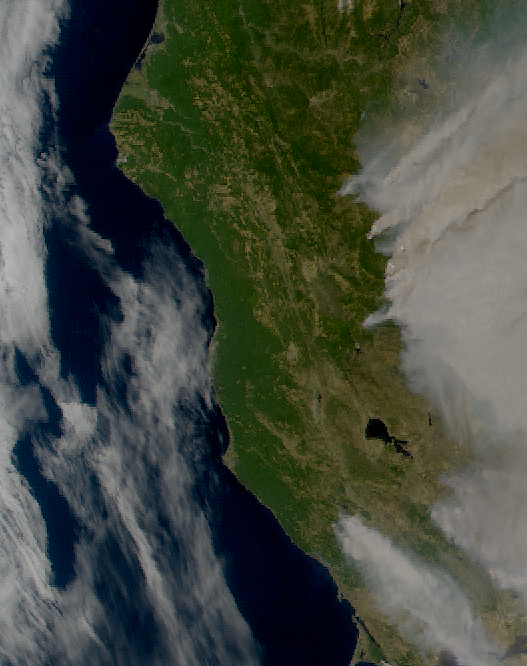

In [13]:
scn_resample.show('true_color')

### Visualize GOES-17 ABI true colour composite with Cartopy features

The satpy library's built-in visualization function is nice, but often you want to make use of additonal features, such as country borders. The library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) offers powerful functions that enable the visualization of geospatial data in different projections and to add additional features to a plot. Below, you will show you how you can visualize the true colour composite with the two Python packages [matplotlib](https://matplotlib.org/) and [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

As a first step, you have to convert the `Scene` object into a numpy array. The numpy array additionally needs to be transposed to a shape that can be interpreted by matplotlib's function `imshow()`: (M,N,3). You can convert a Scene object into a `numpy.array` object with the function `np.asarray()`.

You can use the `.shape` method to see the shape of the numpy array. Note that the interpretation of the 3 axes shown in the shape is `(bands, rows, columns)`.

In [14]:
shape = np.asarray(scn_resample['true_color']).shape
shape

(3, 666, 527)

The shape of the array is `(3, 666, 527)`. This means you have to transpose the array and add index=0 on index position 3.

In [15]:
image = np.asarray(scn_resample['true_color']).transpose(1,2,0)

The next step is then to replace all nan values with 0. You can do this with the numpy function `nan_to_num()`. In a subsequent step, you then scale the values to the range between 0 and 1, clipping the lower and upper percentiles so that a potential contrast decrease caused by outliers is eliminated.


In [16]:
image = np.nan_to_num(image)
image = np.interp(image, (np.percentile(image,1), np.percentile(image,99)), (0, 1))

<br>

Let us now also define a variable for the `coordinate reference system`. You take the `area` attribute from she `scn_resample_nc` Scene and convert it with the function `to_cartopy_crs()` into a format Cartopy can read. You will use the `crs` information for plotting.

In [17]:
crs = scn_resample['true_color'].attrs['area'].to_cartopy_crs()

<br>

Now, you can visualise the true colour composite. The plotting code can be divided in four main parts:
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

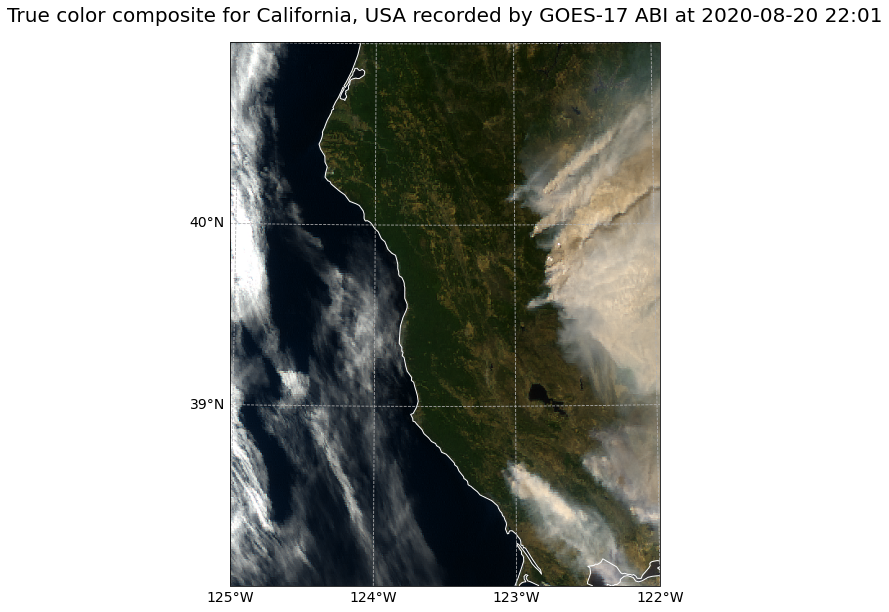

In [18]:
# Initiate a matplotlib figure
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Specify coastlines
ax.coastlines(resolution="10m", color="white")

# Specify a grid
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-140,-110,1), ylocs=range(20,50,1))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plot the numpy array with imshow()
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# Set the title of the plot
plt.title("True color composite for California, USA recorded by GOES-17 ABI at " + scn['C01'].attrs['start_time'].strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)

# Show the plot
plt.show()


## GOES-17 Level 2 Fire-Hot Spot Characterization: Fire Radiative Power

### Load and browse GOES-17 ABI Level 2 Fire Radiative Power data

GOES-17 ABI data is disseminated in the `netcdf` format. You will use the Python library `satpy` to open the data. The results in a `netCDF4.Dataset`, which contains the dataset's metadata, dimension and variable information.

Read more about `satpy` [here](https://github.com/corteva/rioxarray).

From the [Amazon Download Page](https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi), you can download Level 2 data Fire & Hotspot Characterisation data for 20 August 2020 at 22:01 UTC. The data is available in the folder `../data/goes/17/level2/2020/08/20/2201`. Let us load the data. First, you specify the file path and create a variable with the name `file_name2`. Each file contains data from a single band.

In [19]:
file_name2 = glob.glob('../data/goes/17/level2/fires/2020/08/20/2201/*.nc')
file_name2

['../data/goes/17/level2/fires/2020/08/20/2201/OR_ABI-L2-FDCC-M6_G17_s20202332201177_e20202332203549_c20202332204123.nc']

In a next step, you use the `Scene` constructor from the [satpy](https://satpy.readthedocs.io/en/stable/index.html) library. Once loaded, a `Scene` object represents a single geographic region of data, typically at a single continuous time range.

You have to specify the two keyword arguments `reader` and `filenames` in order to successfully load a scene. As mentioned above, for GOES-17 ABI Level 2 data, you can use the `abi_l2_nc` reader.

In [20]:
scn2 =Scene(filenames=file_name2,reader='abi_l2_nc')

scn2

A `Scene` object is a collection of different bands, with the function `available_dataset_names()`, you can see the available bands of the scene. To learn more about the bands of GOES, visit [this website](https://www.goes-r.gov/mission/ABI-bands-quick-info.html).

In [21]:
scn2.available_dataset_names()

['Area', 'Mask', 'Power', 'Temp']

The underlying container for data in satpy is the `xarray.DataArray`. With the function `load()`, you can specify an individual band by name, e.g. `Power` and *load* the data. If you then select the loaded band, you see that the band object is a `xarray.DataArray`.

In [22]:
scn2.load(['Power'])
scn2['Power']

<xarray.DataArray 'Power' (y: 1500, x: 2500)>
dask.array<where, shape=(1500, 2500), dtype=float32, chunksize=(1500, 2500), chunktype=numpy.ndarray>
Coordinates:
    sunglint_angle      float32 10.0
    local_zenith_angle  float32 80.0
    solar_zenith_angle  float32 10.0
    crs                 object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM[...
  * y                   (y) float64 4.588e+06 4.586e+06 ... 1.586e+06 1.584e+06
  * x                   (x) float64 -2.504e+06 -2.502e+06 ... 2.504e+06
Attributes:
    satellite_longitude:  -137.1999969482422
    satellite_latitude:   0.0
    satellite_altitude:   35786023.4375
    long_name:            ABI L2+ Fire-Hot Spot Characterization: Fire Radiat...
    standard_name:        fire_radiative_power
    units:                MW
    resolution:           y: 0.000056 rad x: 0.000056 rad
    grid_mapping:         goes_imager_projection
    cell_measures:        area: Area
    cell_methods:         sunglint_angle: point (no pixel produced) local_zen...
    platform_name:        GOES-17
    sensor:               abi
    name:                 Power
    modifiers:            ()
    scan_mode:            M6
    platform_shortname:   G17
    scene_id:             CONUS
    orbital_slot:         GOES-West
    instrument_ID:        FM2
    production_site:      NSOF
    timeline_ID:          None
    start_time:           2020-08-20 22:01:17.700000
    end_time:             2020-08-20 22:03:54.900000
    reader:               abi_l2_nc
    area:                 Area ID: GOES-West\nDescription: 2km at nadir\nProj...
    _satpy_id:            DataID(name='Power', modifiers=())
    ancillary_variables:  []

With an xarray data structure, you can handle the object as a `xarray.DataArray`. For example, you can print a list of available attributes with the function `attrs.keys()`. 

In [23]:
scn2['Power'].attrs.keys()

dict_keys(['satellite_longitude', 'satellite_latitude', 'satellite_altitude', 'long_name', 'standard_name', 'units', 'resolution', 'grid_mapping', 'cell_measures', 'cell_methods', 'platform_name', 'sensor', 'name', 'modifiers', 'scan_mode', 'platform_shortname', 'scene_id', 'orbital_slot', 'instrument_ID', 'production_site', 'timeline_ID', 'start_time', 'end_time', 'reader', 'area', '_satpy_id', 'ancillary_variables'])

With the `attrs()` function, you can also access individual metadata information, e.g. `start_time` and `end_time`.

In [24]:
scn2['Power'].attrs['start_time'], scn2['Power'].attrs['end_time']

(datetime.datetime(2020, 8, 20, 22, 1, 17, 700000),
 datetime.datetime(2020, 8, 20, 22, 3, 54, 900000))

## Generate a geographical subset around California (2km)

Let us generate a geographical subset around northern California and resample it to 2km, which is the resolution of the Level 2 data. . You can do this with the function stored in the `coord2area_def.py` script which converts human coordinates (longitude and latitude) to an area definition. 

You need to define the following arguments: 
- `name` :the name of the area definition, set this to `california_2km`
- `proj` : the projection, set this to `laea` which stands for the Lambert azimuthal equal-area projection
- `min_lat`: the minimum latitude value, set this to `38`
- `max_lat`: the maximum latitude value, set this to `41`
- `min_lon`: the minimum longitude value, set this to `-125`
- `max_lon`: the maximum longitude value, set this to `-122`
- `resolution(km)`: the resolution in kilometres, set this to `2`

Afterwards, you can visualize the resampled image with the function `show()`.

In [25]:
%run coord2area_def.py california_2km laea 38 41 -125 -122 2

### +proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84

california_2km:
  description: california_2km
  projection:
    proj: laea
    ellps: WGS84
    lat_0: 39.5
    lon_0: -123.5
  shape:
    height: 167
    width: 132
  area_extent:
    lower_left_xy: [-131748.033787, -165429.793658]
    upper_right_xy: [131748.033787, 167607.077655]


From the values generated by `coord2area_def.py`, you copy and paste several into the template below. 

You need to define the following arguments in the code block template below: 
- `area_id` (string): the name of the area definition, set this to `'california_2km'`
- `x_size` (integer): the number of values for the width, set this to the value of the shape `width`, which is `772`
- `y_size` (integer): the number of values for the height, set this to the value of the shape `height`, which is `830`
- `area_extent` (set of coordinates in brackets): the extent of the map is defined by 2 sets of coordinates, within a set of brackets `()` paste in the values of the `lower_left_xy` from the area_extent above, followed by the `upper_right_xy` values. You should end up with `(-772227.100776, -800023.179953, 772227.100776, 860185.044621)`.
- `projection` (string): the projection, paste in the first line after `###` starting with `+proj`, e.g. `'+proj=laea +lat_0=37.5 +lon_0=-122.0 +ellps=WGS84'` 
- `description` (string): Give this a generic name for the region, such as `'California'`
- `proj_id` (string): A recommended format is the projection short code followed by lat_0 and lon_0, e.g. `'laea_37.5_-122.0'`

Next, use the area definition to resample the loaded Scene object.

You should end up with the following code block.

In [26]:
from pyresample import get_area_def

area_id = 'california_2km'

x_size = 167
y_size = 132
area_extent = (-131748.033787, -165429.793658, 131748.033787, 167607.077655)
projection = '+proj=laea +lat_0=39.5 +lon_0=-123.5 +ellps=WGS84'
description = "California"
proj_id = 'laea_39.5_-123.5'

areadef2 = get_area_def(area_id, description, proj_id, projection,x_size, y_size, area_extent)

Next, use the area definition to resample the loaded Scene object.

In [27]:
scn_resample2 = scn2.resample(areadef2)

Afterwards, you can visualize the resampled image with the function `show()`.

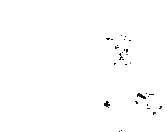

In [28]:
scn_resample2.show('Power')

<br>

## Visualize GOES-17 ABI Fire Radiative Power and true color composite with Cartopy features

You can make use of the `ListedColorMap` function from the matplotlib library to define the colors for each fire radiative power (FRP) class.

In [29]:
frp_cm = ListedColormap([[0, 0, 255./255.],
                        [176./255., 196./255., 222./255.],
                        [255./255., 255./255., 0],
                        [1., 140./255., 0],
                        [178./255., 34./255., 34./255.],
                        [1, 0, 0]])

You can define the levels for the respective FRP classes in a list stored in the variable `bounds`. You can also use the `.BoundaryNorm()` function from `matplotlib.colors` to define the norm that you will use for plotting later. 

In [30]:
bounds = [0, 250, 500, 750, 1000, 1500, 2000]
norm = BoundaryNorm(bounds, frp_cm.N)

Finally, let's try to plot the GOES-17 ABI Level 1B composite and the Level 2 FRP data together.

The plotting code can be divided in five main parts:
* **Copy the coordinate reference system for the FRP data**
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, US states and a grid**: specify additional features to be added to the plot
* **Plotting function**: plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

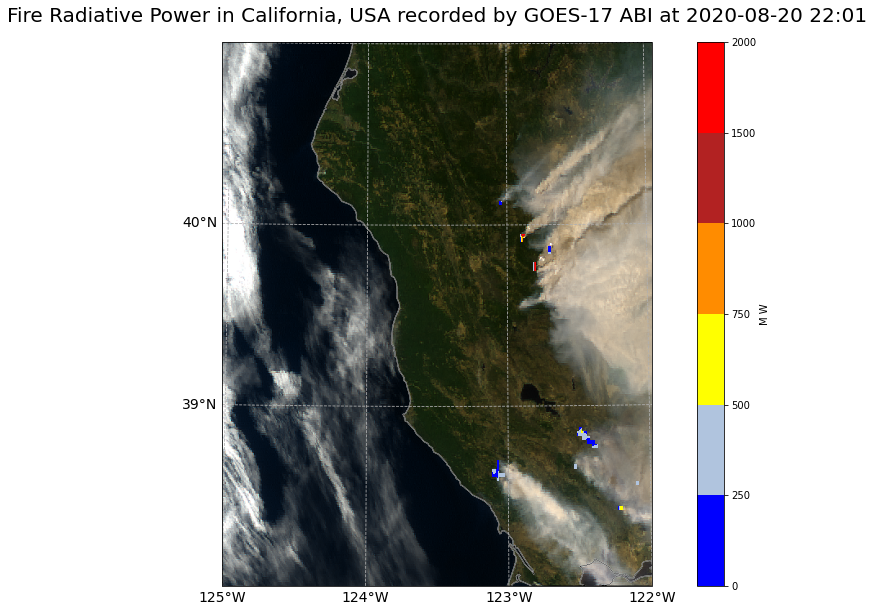

In [31]:
# Define our FRP image
image2 = scn_resample2['Power']

# Now you can "copy" the coordinate reference system from the FRP data
crs2 = scn_resample2['Power'].attrs["area"].to_cartopy_crs()

# Initiate a matplotlib figure using the coordinate reference system of the Level 1B data
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)

# Specify coastlines
ax.coastlines(resolution="10m", color="white")

# Specify the US States
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

# Specify a grid
gl = ax.gridlines(draw_labels=True, linestyle='--', xlocs=range(-125,-114,1), ylocs=range(25,42,1))
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plot the image data from the Level 1B true colour composite
ax.imshow(image, transform=crs, extent=crs.bounds, origin="upper")

# Plot the image data from the Level 2 FRP data
plt.imshow(image2, transform=crs2, extent=crs2.bounds, origin="upper", cmap=frp_cm, norm=norm)

# Add a colour bar and set the label of the units to M W or megawatts
cbar = plt.colorbar(cmap=frp_cm, norm=norm, boundaries=bounds)
cbar.set_label("M W")

# Set the title of the plot
plt.title("Fire Radiative Power in California, USA recorded by GOES-17 ABI at " + scn2['Power'].attrs['start_time'].strftime("%Y-%m-%d %H:%M"), fontsize=20, pad=20.0)

# Show the plot
plt.show()

<hr>

### References
* GOES-R Calibration Working Group and GOES-R Series Program. (2017). <i>NOAA GOES-R Series Advanced Baseline Imager (ABI) Level 1b Radiances.</i> NOAA National Centers for Environmental Information. doi:10.7289/V5BV7DSR.

* GOES-R Calibration Working Group and GOES-R Series Program. (2017). <i>NOAA GOES-R Series Advanced Baseline Imager (ABI) Level 2 fire and Hotspot Characterisation.</i> NOAA National Centers for Environmental Information. doi:10.7289/V5BV7DSR.

* Some code in this notebook was adapted from the following sources:
    * origin: https://python-kurs.github.io/sommersemester_2019/units/S01E07.html
    * copyright: 2019, Marburg University
    * license: CC BY-SA 4.0
    * retrieved: 2022-06-28 by Sabrina Szeto

```{admonition} Return to the case study
Monitoring fires with next-generation satellites from MTG and Metop-SG: Californian Wildfires Case Study <br>
[](ca_part1_fig3)
```